# Analysis pipeline for concatenated recordings

Formozov, A., Chini, M. et al.
Calcium imaging and electrophysiology of hippocampal activity under anesthesia and natural sleep in mice.

2021

*** To save notebook as pdf without code: ***
https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code?noredirect=1&lq=1

In [12]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

### Download and compile OASIS

In [13]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  !wget https://raw.githubusercontent.com/mchini/Yang_Chini_et_al/testTransition/notebooks/capipeline.py
  !git clone https://github.com/j-friedrich/OASIS.git
  !pwd
  %cd /content/OASIS/
  !pwd
  import warnings
  warnings.filterwarnings("ignore")
  !python setup.py build_ext --inplace
  %cd ..
  !pwd
  from sys import path
  path.append(r'/content/OASIS')
else:
  print('Not running on CoLab')

Not running on CoLab


In [14]:
from capipeline import *

# Upload and reprocess data or upload pre-processed data (see below)

### Upload data from GIN

At the rate 0.5 MB/s, it takes abouts 30 min (1.5 GB of data, one animal, one condition for transition state recordings)

In [10]:
# mimic path TS_C_MMF_8237 (transition state, concatenated, MMF, animal 8237)
full_path = "/media/andrey/My Passport/GIN/backup_Anesthesia_CA1/calcium imaging transition state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0"
from pathlib import Path
path = Path('.' + full_path)
path.mkdir(parents=True, exist_ok=True)

In [7]:
# download data
%cd "./media/andrey/My Passport/GIN/backup_Anesthesia_CA1/calcium imaging transition state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0"
download_path = "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/Anesthesia/calcium_imaging_transition_state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0/"
files = ["iscell.npy","stat.npy","F.npy","Fneu.npy"]
for f in files:
    link = download_path + f
    !wget $link
    
%cd "../../../../../../../../../../"

# download meta_data
!wget "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/meta_data/meta_recordings_transition_state.xlsx"

/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/Anesthesia_CA1/calcium imaging transition state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0
--2021-05-05 17:31:56--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/calcium%20imaging%20transition%20state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0/iscell.npy
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-05-05 17:31:56 ERROR 404: Not Found.

--2021-05-05 17:31:56--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/calcium%20imaging%20transition%20state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0/stat.npy
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-05-05 17:31:57 ER

### Setup path and choose animals for the analysis

In [11]:
animals =['TS_C_MMF_8237']

database_path = './meta_recordings_transition_state.xlsx'

rec = get_recordings_for_animals(animals, database_path)

print("Recordings for the analysis: " + str(rec) )

Recordings for the analysis: [18, 19, 20, 21, 22, 23, 24, 25, 26]


### Plot raster plot for the first three recordings 

Total trace length: 85000
Recording length: 5694
Analysis periods: [0, 5000]
Analysis period total frames:  5000
Total trace length: 85000
Recording length: 9000
Analysis periods: [0, 5000]
Analysis period total frames:  5000
Total trace length: 85000
Recording length: 7269
Analysis periods: [2100, 7100]
Analysis period total frames:  5000


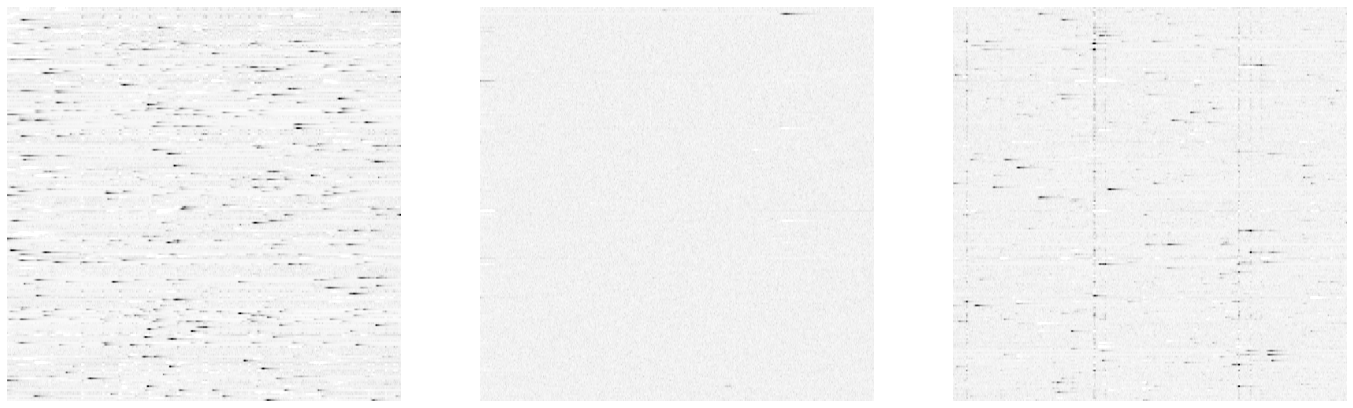

In [9]:
from capipeline import get_raster

nrec_to_plot = 3

starting_recording = rec[0]

fig, axes = plt.subplots(1, nrec_to_plot, figsize=(8*nrec_to_plot, 8), sharex=True)

for j in range(0,nrec_to_plot):
   
    raster = get_raster(starting_recording+j, 200, database_path, concatenation=True)
    
    axes[j].imshow(raster,extent=(0,7000,0,7000),cmap='Greys',vmin=0.25,vmax=1.0)
    
    axes[j].axis('off')

plt.show()

TS_C_MMF_8237 18 
Threshold for peak detection: 160
18 TS_C_MMF_8237 awake
Total trace length: 85000
Recording length: 5694
Analysis periods: [0, 5000]
Analysis period total frames:  5000


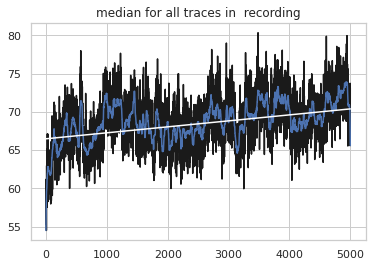

Median baseline: 34.51


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 19 
Threshold for peak detection: 160
19 TS_C_MMF_8237 mmf
Total trace length: 85000
Recording length: 9000
Analysis periods: [0, 5000]
Analysis period total frames:  5000


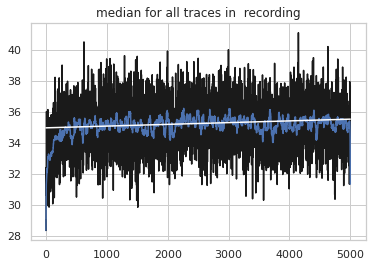

Median baseline: 12.73


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 20 
Threshold for peak detection: 160
20 TS_C_MMF_8237 post30
Total trace length: 85000
Recording length: 7269
Analysis periods: [2100, 7100]
Analysis period total frames:  5000


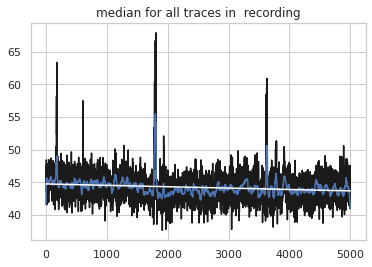

Median baseline: 18.22


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 21 
Threshold for peak detection: 160
21 TS_C_MMF_8237 post60
Total trace length: 85000
Recording length: 15035
Analysis periods: [4000, 9000]
Analysis period total frames:  5000


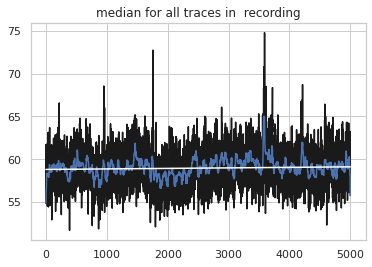

Median baseline: 28.29


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 22 
Threshold for peak detection: 160
22 TS_C_MMF_8237 post120
Total trace length: 85000
Recording length: 16532
Analysis periods: [10500, 16500]
Analysis period total frames:  6000


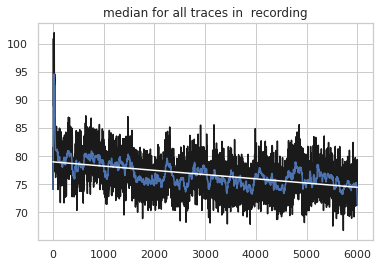

Median baseline: 42.96


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 23 
Threshold for peak detection: 160
23 TS_C_MMF_8237 post180
Total trace length: 85000
Recording length: 8118
Analysis periods: [0, 5000]
Analysis period total frames:  5000


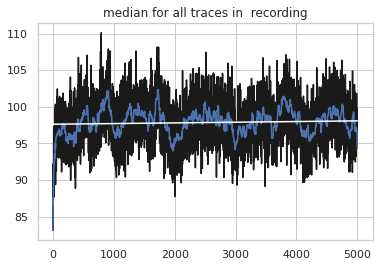

Median baseline: 61.95


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 24 
Threshold for peak detection: 160
24 TS_C_MMF_8237 post240
Total trace length: 85000
Recording length: 9768
Analysis periods: [0, 5000]
Analysis period total frames:  5000


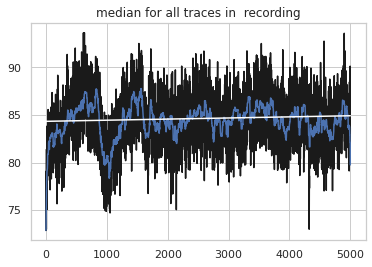

Median baseline: 51.24


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 25 
Threshold for peak detection: 160
25 TS_C_MMF_8237 post300
Total trace length: 85000
Recording length: 6845
Analysis periods: [0, 5000]
Analysis period total frames:  5000


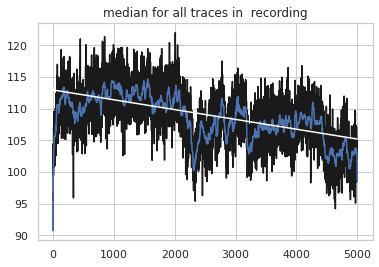

Median baseline: 74.40


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****
TS_C_MMF_8237 26 
Threshold for peak detection: 160
26 TS_C_MMF_8237 post360
Total trace length: 85000
Recording length: 6736
Analysis periods: [0, 5000]
Analysis period total frames:  5000


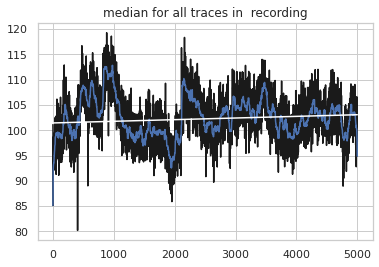

Median baseline: 64.36


/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrey/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Number of neurons accepted: 1170
*****


In [29]:
#### WHAT TO DO WITH EXCLUDED VALUES???

df_estimators = pd.DataFrame()

df_corrs =  pd.DataFrame()

for r in rec:
    
    animal = get_animal_from_recording(r, database_path)
    
    print(str(animal) + " " + str(r) + " ")

    if (animal=='TS_C_MMF_8237'): ### assign threshold
         threshold = 160
        
    print("Threshold for peak detection: " + str(threshold))
    df_e, df_c   = get_data_frame(r, database_path, threshold=threshold, baseline_correction=True,concatenation=True)

    df_estimators = pd.concat([df_estimators,df_e])
    df_corrs = pd.concat([df_corrs,df_c])

    print("*****")

    
df_estimators['neuronID'] = df_estimators.index

### Store data frames

In [96]:
df_estimators.to_pickle("./df_estimators_TS_C_MMF_8237_n_peaks_baseline.pkl") 
df_corrs.to_pickle("./df_corrs_TS_C_MMF_8237_n_peaks_baseline.pkl") 

# Load reprocessed data

In [22]:
df_estimators = pd.read_pickle("./df_estimators_TS_C_MMF_8237_n_peaks_baseline.pkl")
df_corrs = pd.read_pickle("./df_corrs_TS_C_MMF_8237_n_peaks_baseline.pkl")

### Check availible conditions

In [23]:
np.unique(df_estimators.condition)

array(['awake'], dtype=object)

### Get statistics on the features and correlations 

**Main features (df_estimators):**

- n_peaks
- width.median
- height.median
- decay time
- skewness
- integral
- baseline
- number of active neurons

**Correlations (df_corrs):**

- Pearson correlation of neurons 
- absolute Pearson correlation of neurons

In [25]:
df_estimators.describe()

,recording,neuronID,n.accepted,length.frames,length.minutes,n.accepted_and_rejected,traces.median,npil.median,trace.std,npil.std,...,baseline.oasis,integral,Tm0p7Ncorr.mean,peak_detection_threshold,decay_isol,decay_no_isol,n_peaks,n_peaks_per_recording,height.median,width.median
count,1170.0,1170.000000,1170.0,1170.0,1.170000e+03,1170.0,1170.000000,1170.000000,1170.000000,1170.000000,...,1170.000000,1170.000000,1170.000000,1170.0,1170.000000,1170.000000,1170.000000,1170.000000,927.000000,927.000000
mean,18.0,584.500000,1170.0,5000.0,2.777778e+00,2429.0,255.251984,229.560623,37.246487,37.246487,...,28.064704,79.160479,0.001450,160.0,2.880588,0.799392,39.020000,108.388889,275.581727,62.966575
std,0.0,337.894214,0.0,0.0,4.442791e-16,0.0,158.030884,118.384392,35.171715,35.171715,...,47.247816,120.652066,0.004672,0.0,8.423243,0.473489,43.058463,119.606841,127.636305,186.931385
min,18.0,0.000000,1170.0,5000.0,2.777778e+00,2429.0,0.000000,42.001099,5.197093,5.197093,...,0.000000,-405.454900,-0.015918,160.0,0.004825,0.009628,0.000000,0.000000,160.421005,1.847015
25%,18.0,292.250000,1170.0,5000.0,2.777778e+00,2429.0,139.772797,135.307068,15.184301,15.184301,...,0.000000,6.825266,-0.001492,160.0,0.219653,0.396309,0.720000,2.000000,188.807022,11.797760
50%,18.0,584.500000,1170.0,5000.0,2.777778e+00,2429.0,211.672272,200.356491,24.519712,24.519712,...,4.877923,53.868281,0.001314,160.0,0.429830,0.837350,18.720000,52.000000,230.342270,17.782162
75%,18.0,876.750000,1170.0,5000.0,2.777778e+00,2429.0,337.379974,309.607544,46.091641,46.091641,...,40.522475,126.459712,0.004607,160.0,0.613399,1.230723,77.400000,215.000000,311.823196,42.640527
max,18.0,1169.000000,1170.0,5000.0,2.777778e+00,2429.0,1182.330200,661.335510,272.301208,272.301208,...,610.613955,807.172700,0.016444,160.0,33.316664,1.629374,131.760000,366.000000,1115.017456,3590.921067


In [6]:
df_corrs.describe()

,recording,Tm0p7Ncorr,Tm0p7Ncorr.abs
count,1.232010e+07,1.230957e+07,1.230957e+07
mean,2.200000e+01,9.229237e-04,3.036242e-02
std,2.581989e+00,5.583744e-02,4.686998e-02
min,1.800000e+01,-9.883481e-01,3.660796e-09
25%,2.000000e+01,-1.709684e-02,7.662017e-03
50%,2.200000e+01,-8.603377e-05,1.701841e-02
75%,2.400000e+01,1.693834e-02,3.396463e-02
max,2.600000e+01,9.913196e-01,9.913196e-01


### Get median value of the feature for a given animal

In [7]:
df_estimators[(df_estimators.animal=='TS_C_MMF_8237')].groupby('condition', as_index=False)['n_peaks'].median()

,condition,n_peaks
0,awake,18.72
1,mmf,0.00
2,post120,30.30
3,post180,35.46
4,post240,25.56
5,post30,4.32
6,post300,42.12
7,post360,42.84
8,post60,18.00


In [102]:
df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.999)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median()

,condition,Tm0p7Ncorr.abs
0,awake,0.026326
1,mmf,0.009634
2,post120,0.014517
3,post180,0.017756
4,post240,0.016682
5,post30,0.014929
6,post300,0.023240
7,post360,0.036034
8,post60,0.013139


### Violin plot for a given feature

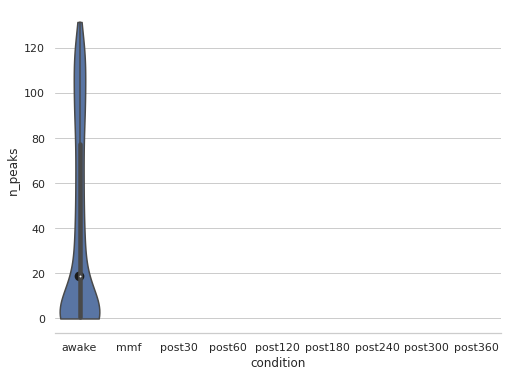

In [28]:
feature = 'n_peaks' # number of peaks per min
conditions = ["awake","mmf","post30","post60","post120","post180","post240","post300","post360"]

f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.despine(left=True)
#axes.set_ylim([0, 100.0])
sns.violinplot(x='condition', y=feature, data=df_estimators,ax=axes,order = conditions,scale='width',cut=0)
sns.pointplot(x='condition', y=feature, markers='o', scale=1.1, color='k',data=df_estimators.groupby('condition', as_index=False)[feature].median(), ax=axes,order=conditions)
plt.savefig("n_peaks.png")
plt.savefig("n_peaks.eps")

### Violin plot for correlations

Text(0, 0.5, 'Absolute Pearson Correlation')

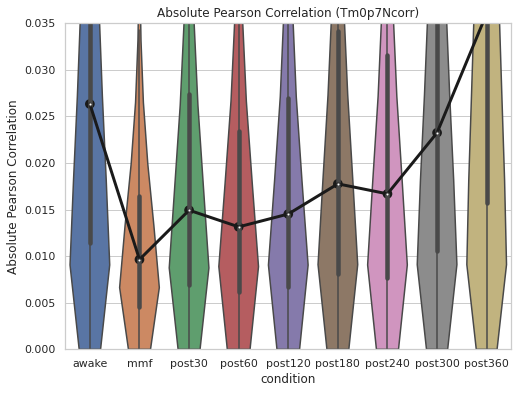

In [11]:
plt.rcParams['figure.figsize'] = [8, 6]

sns.violinplot(x='condition', y='Tm0p7Ncorr.abs',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)],order=["awake","mmf","post30","post60","post120","post180","post240","post300","post360"],scale='width',cut=0)
sns.pointplot(x='condition', y='Tm0p7Ncorr.abs', markers='o', scale=1.1, color='k',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median(),order=["awake","mmf","post30","post60","post120","post180","post240","post300","post360"])

plt.ylim([-0.00,0.035])
#plt.yscale('log')
#plt.savefig("correlations.png")
#plt.savefig("correlations.eps")
plt.title("Absolute Pearson Correlation (Tm0p7Ncorr)")
plt.ylabel("Absolute Pearson Correlation")


# Single-neuron level analysis

In [26]:
df_estimators['neuronID'] = df_estimators.index # make a column from neuronID (to be removed from here and added to the reprocessing)

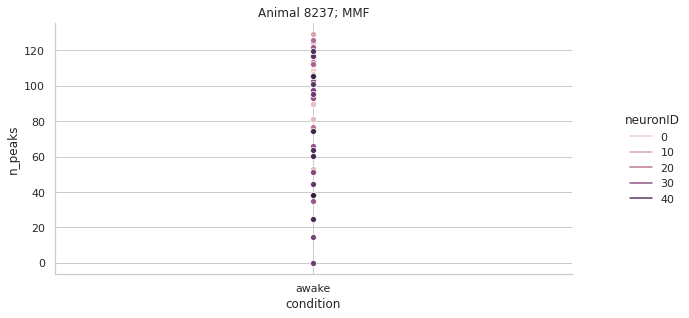

In [27]:
g=sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators[df_estimators.neuronID<50], marker='o',hue='neuronID',kind='line')
g.fig.set_size_inches(10,4)
plt.title("Animal 8237; MMF")
plt.savefig("single-neuron-level-analysis.png")
plt.savefig("single-neuron-level-analysis.eps")

# Single-neuron level analysis (interactive)

### Number of transients in different conditions; color represents median hight of transients, while size their median decay time

In [7]:
import plotly.express as px

x_axis = "condition"
y_axis = "n_peaks"
line_group = "neuronID"
color = "neuronID"

fig = px.line(df_estimators[df_estimators.neuronID<50], x=x_axis, y=y_axis, line_group=line_group,color=color,width=1000, height=600)

#fig.write_image("n_peaks_interactive.svg")

fig.show()

In [6]:
import plotly.express as px

x_axis = "condition"
y_axis = "n_peaks"
marker_color = "height.median"
marker_size = 'decay_no_isol'

fig = px.scatter(df_estimators[df_estimators.neuronID<50], x=x_axis, y=y_axis, color=marker_color,
                 size=marker_size,width=1000, height=600)
#fig.write_image("n_peaks_scatter_interactive.eps")
#fig.write_image("n_peaks_scatter_interactive.png")
fig.show()